# Testing for differences between sites using three different sampling

designs

Alex Koiter

## Load Libraries

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'scales'

The following object is masked from 'package:purrr':

    discard

The following object is masked from 'package:readr':

    col_factor

Loading required package: viridisLite

Attaching package: 'viridis'

The following object is masked from 'package:scales':

    viridis_pal

## FSA v0.9.5. See citation('FSA') if used in publication.
## Run fishR() for related website and fishR('IFAR') for related book.

## Load data

In [ ]:
psa <- read.csv(here::here("./notebooks/PSA_data.csv")) %>%
  rename(site = Site) %>%
  select(site, sample_number, sampling_design, dx_50, specific_surface_area) %>%
  filter(sampling_design != "Fine scale")  

om <- read.csv(here::here("./notebooks/OM_data.csv")) %>%
  rename(site = Site, sampling_design = Sampling_Design, sample_number = Sample_Number) %>%
  select(OM, site, sampling_design, sample_number) %>%
  filter(sampling_design != "Fine scale") %>%
  mutate(site = recode(site, Agricultural = "Agriculture")) 

geo <- read.csv(here::here("./notebooks/Geochemistry analysis - Copy 2.csv")) %>%
  select(-X) %>%
  rename(sampling_design = sample_design) %>%
  filter(sampling_design != "Fine scale")  

colour <- read.csv(here::here("./notebooks/final results revised.csv")) %>%
  select(-X.1) %>%
  rename(sampling_design = sample_design) %>%
  filter(sampling_design != "Fine scale") 

## Kruskal Wallis test

### Colour

In [ ]:
kruskal_colour <- colour %>%
  pivot_longer(cols = X:B, names_to = "Fingerprint", values_to = "value") %>%
  nest(data = c(-Fingerprint, - site)) %>%
  mutate(k_test = map(data, ~kruskal.test(value ~ sampling_design, data = .))) %>%
  mutate(p_value = map_dbl(k_test, ~ .$p.value)) %>%
  select(site, Fingerprint,p_value)%>%
  mutate(type = "colour")
  
kruskal_colour 

# A tibble: 30 × 4
   site        Fingerprint    p_value type  
   <chr>       <chr>            <dbl> <chr> 
 1 Agriculture X           0.0526     colour
 2 Agriculture Y           0.0567     colour
 3 Agriculture Z           0.530      colour
 4 Agriculture x           0.0000370  colour
 5 Agriculture y           0.00000552 colour
 6 Agriculture u           0.0000173  colour
 7 Agriculture v           0.00000769 colour
 8 Agriculture L           0.0567     colour
 9 Agriculture a           0.0000362  colour
10 Agriculture b           0.0000104  colour
# ℹ 20 more rows

### Geochemistry

In [ ]:
kruskal_geo <- geo %>%
  pivot_longer(cols = Ag:Zr, names_to = "Fingerprint", values_to = "value") %>%
  nest(data = c(-Fingerprint, - site)) %>%
  mutate(k_test = map(data, ~kruskal.test(value ~ sampling_design, data = .))) %>%
  mutate(p_value = map_dbl(k_test, ~ .$p.value)) %>%
  select(site, Fingerprint,p_value) %>%
  mutate(type = "geochemistry") %>%
  filter(Fingerprint %in% c("Ag", "Al", "As","B","Ba","Be","Bi","Ca","Cd","Ce","Co", "Cr", "Cs", "Cu", "Fe", "Ga", "Hf", "Hg", "In", "K", "La", "Li", "Mg", "Mn", "Mo", "Nb", "Ni", "P", "Pb", "Rb", "S", "Sb", "Sc", "Se", "Sn", "Sr", "Te", "Th", "Tl", "U", "V", "Y", "Zn", "Zr"))
kruskal_geo 

# A tibble: 88 × 4
   site   Fingerprint  p_value type        
   <chr>  <chr>          <dbl> <chr>       
 1 Forest Ag          0.00218  geochemistry
 2 Forest Al          0.000205 geochemistry
 3 Forest As          0.00640  geochemistry
 4 Forest B           0.00786  geochemistry
 5 Forest Ba          0.00558  geochemistry
 6 Forest Be          0.000968 geochemistry
 7 Forest Bi          0.000413 geochemistry
 8 Forest Ca          0.000155 geochemistry
 9 Forest Cd          0.000229 geochemistry
10 Forest Ce          0.0661   geochemistry
# ℹ 78 more rows

### plotting

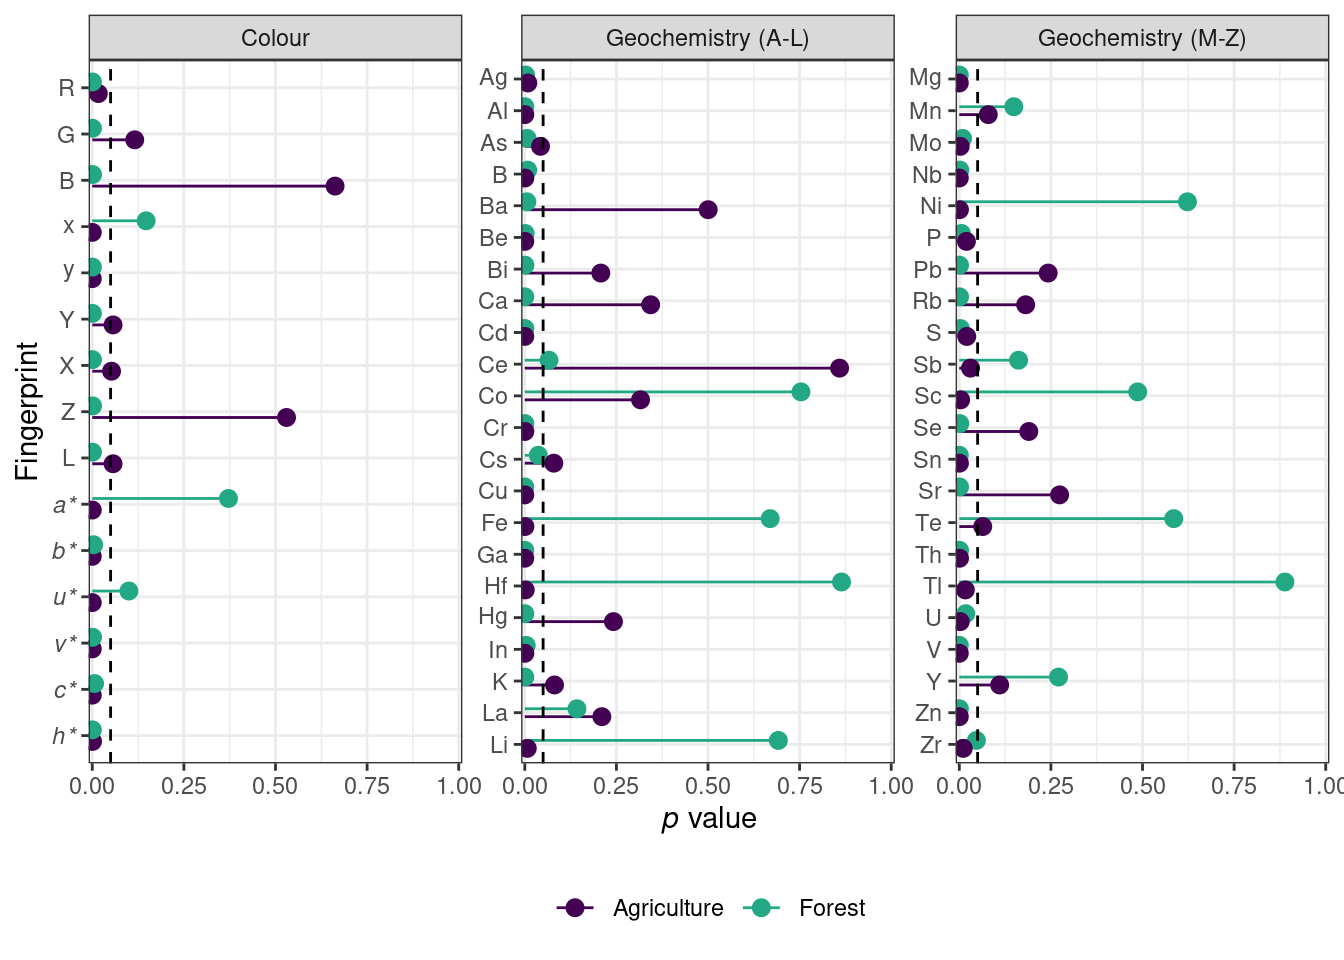

In [ ]:
plot_ele <- c("Ag", "Al", "As", "B",  "Ba", "Be", "Bi", "Ca", "Cd", "Ce", "Co", "Cr", "Cs", "Cu", "Fe", "Ga", "Hf", "Hg", "In", "K",  "La", "Li")

kruskal_p <- kruskal_colour %>%
  bind_rows(kruskal_geo) %>%
  mutate(start = 0) %>%
  mutate(group = case_when(type == "colour" ~ "Colour",
                           type == "geochemistry" & Fingerprint %in% plot_ele ~ "Geochemistry (A-L)",
                           type == "geochemistry" & !Fingerprint %in% plot_ele ~ "Geochemistry (M-Z)")) %>%
  mutate(
    Fingerprint = fct_relevel(
      Fingerprint,
      c("R", "G", "B", "x", "y", "Y", "X", "Z", "L", "a", "b", "u", "v", "c", "h")),
    Fingerprint = fct_relevel(Fingerprint, c("Ag", "Al", "As"), 
                              after = which(levels(Fingerprint) == "B") - 1),
    Fingerprint = fct_relevel(Fingerprint, c("Mg", "Mn", "Mo", "Nb", "Ni", "P", "Pb", "Rb", "S", 
                                             "Sb", "Sc", "Se", "Sn", "Sr", "Te", "Th", "Tl", "U", "V"), 
                              after = which(levels(Fingerprint) == "Y") - 1)) %>%
  mutate(Fingerprint = fct_recode(
    Fingerprint, 
    "italic(`a*`)" = "a", "italic(`b*`)" = "b", "italic(`c*`)" = "c", "italic(`h*`)" = "h", 
    "italic(`u*`)" = "u",  "italic(`v*`)" = "v"))

p1 <- ggplot(data = kruskal_p, aes(y = fct_relevel(Fingerprint, rev), x = p_value, colour = site)) +
  #geom_point(position = position_dodge(width = 0.2)) +
  geom_pointrange(aes(xmax= p_value, xmin = 0), position = position_dodge(width = 0.5), linewidth = 0.5) +
  geom_vline(xintercept = 0.05, linetype = "dashed") +
  theme_bw() +
  scale_x_continuous(expand = c(0.01,0), limits = c(0,1)) +
  scale_y_discrete(labels = label_parse()) +
  scale_colour_viridis_d(begin = 0, end = 0.6) +
  theme(legend.position = "bottom",
        legend.title = element_blank()) +
  labs(x = expression(paste(italic("p"), " value")), y = "Fingerprint") +
  facet_wrap(~group, scales = "free_y")

p1

## Dunns test

Post-hoc test

In [ ]:
kw_geo_pass <- filter(kruskal_geo, p_value <0.05) %>%
  rename("fingerprint" = "Fingerprint")

dunngeo <- geo %>%
  pivot_longer(cols = Ag:Zr, names_to = "fingerprint", values_to = "value") %>%
  semi_join(kw_geo_pass, by = c("fingerprint", "site")) %>%
  select(-sample_number) %>%
  mutate(sampling_design = as.factor(sampling_design)) %>%
  nest(data = c(-fingerprint, - site)) %>%
  mutate(dunn_test = map(data, ~dunnTest(value ~ sampling_design, data = .,
                                         method = "bh"))) %>%
  mutate(p_value = map(dunn_test, ~ .$res)) %>%
  unnest(p_value) %>%
  mutate(type = "Geochemistry")

kw_colour_pass <- filter(kruskal_colour, p_value <0.05) %>%
  rename("fingerprint" = "Fingerprint")

dunncolour <- colour %>%
  pivot_longer(cols = X:B, names_to = "fingerprint", values_to = "value") %>%
  semi_join(kw_colour_pass, by = c("fingerprint", "site")) %>%
  select(-sample_number) %>%
  mutate(sampling_design = as.factor(sampling_design)) %>%
  nest(data = c(-fingerprint, - site)) %>%
  mutate(dunn_test = map(data, ~dunnTest(value ~ sampling_design, data = .,
                                         method = "bh"))) %>%
  mutate(p_value = map(dunn_test, ~ .$res)) %>%
  unnest(p_value) %>%
  mutate(type = "Colour")

### Plotting

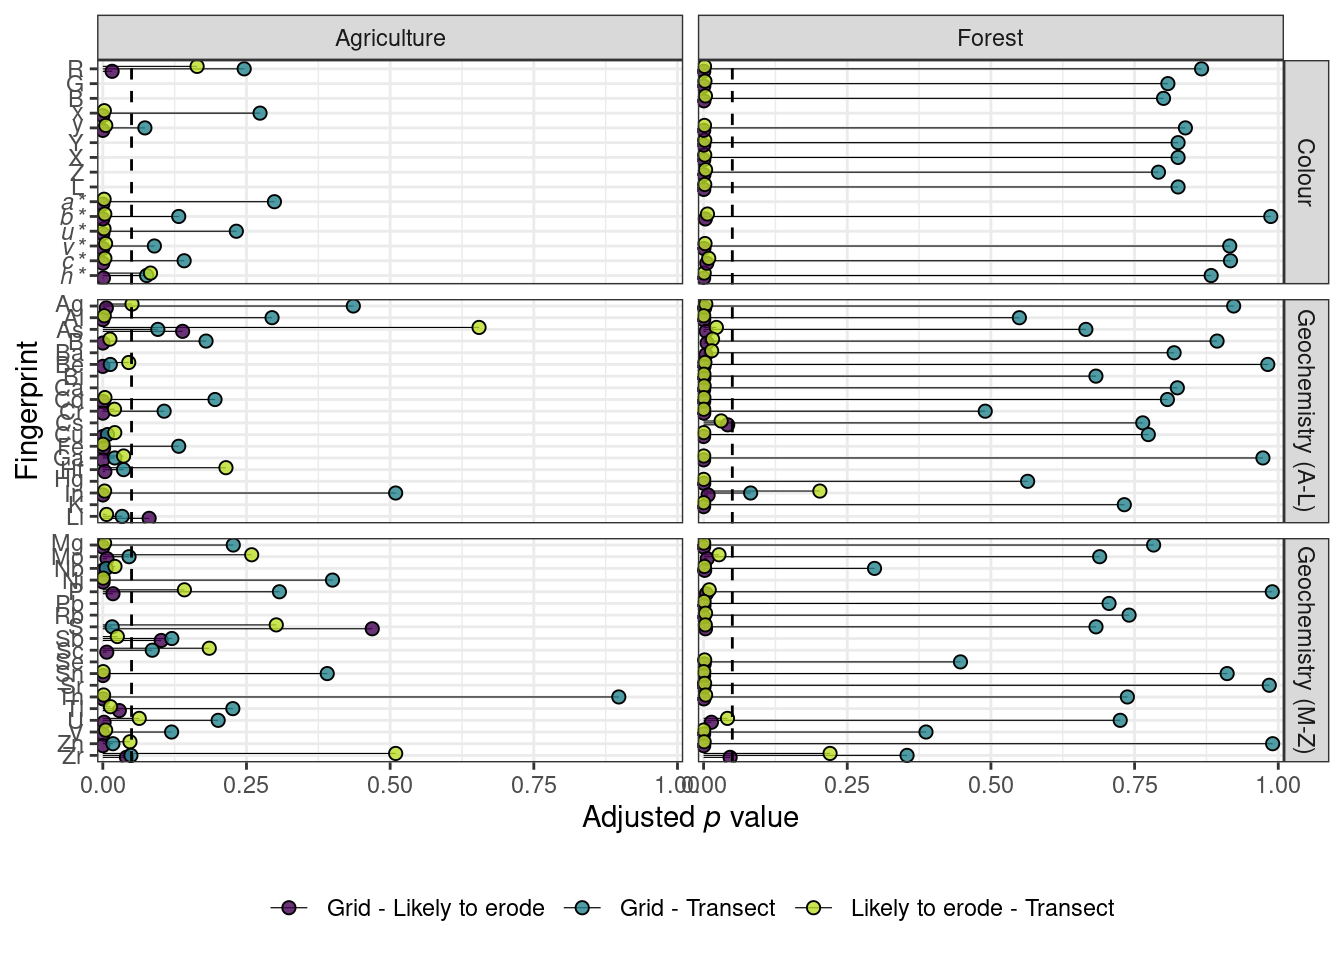

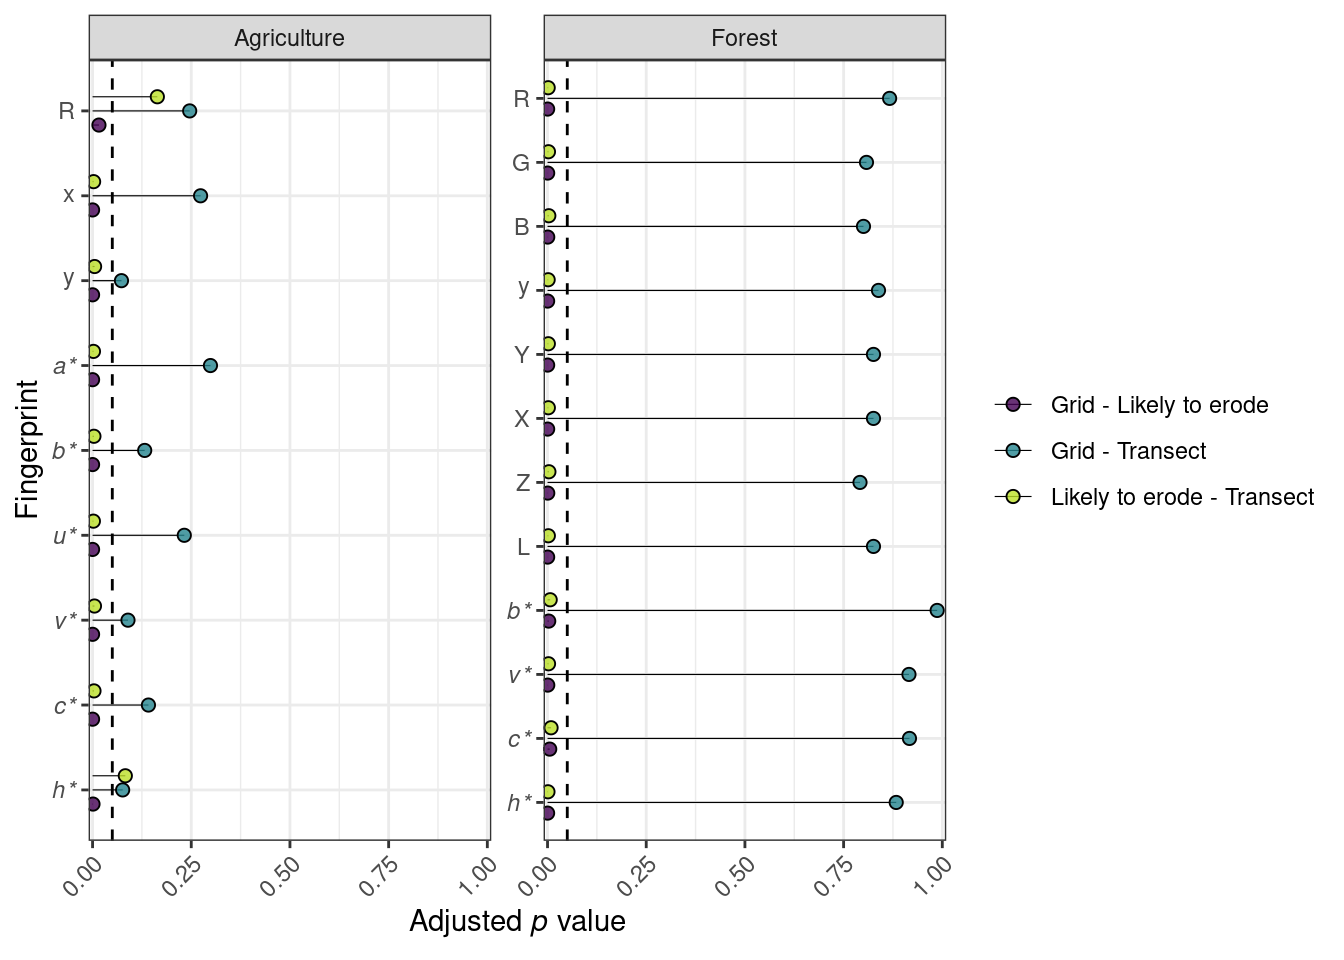

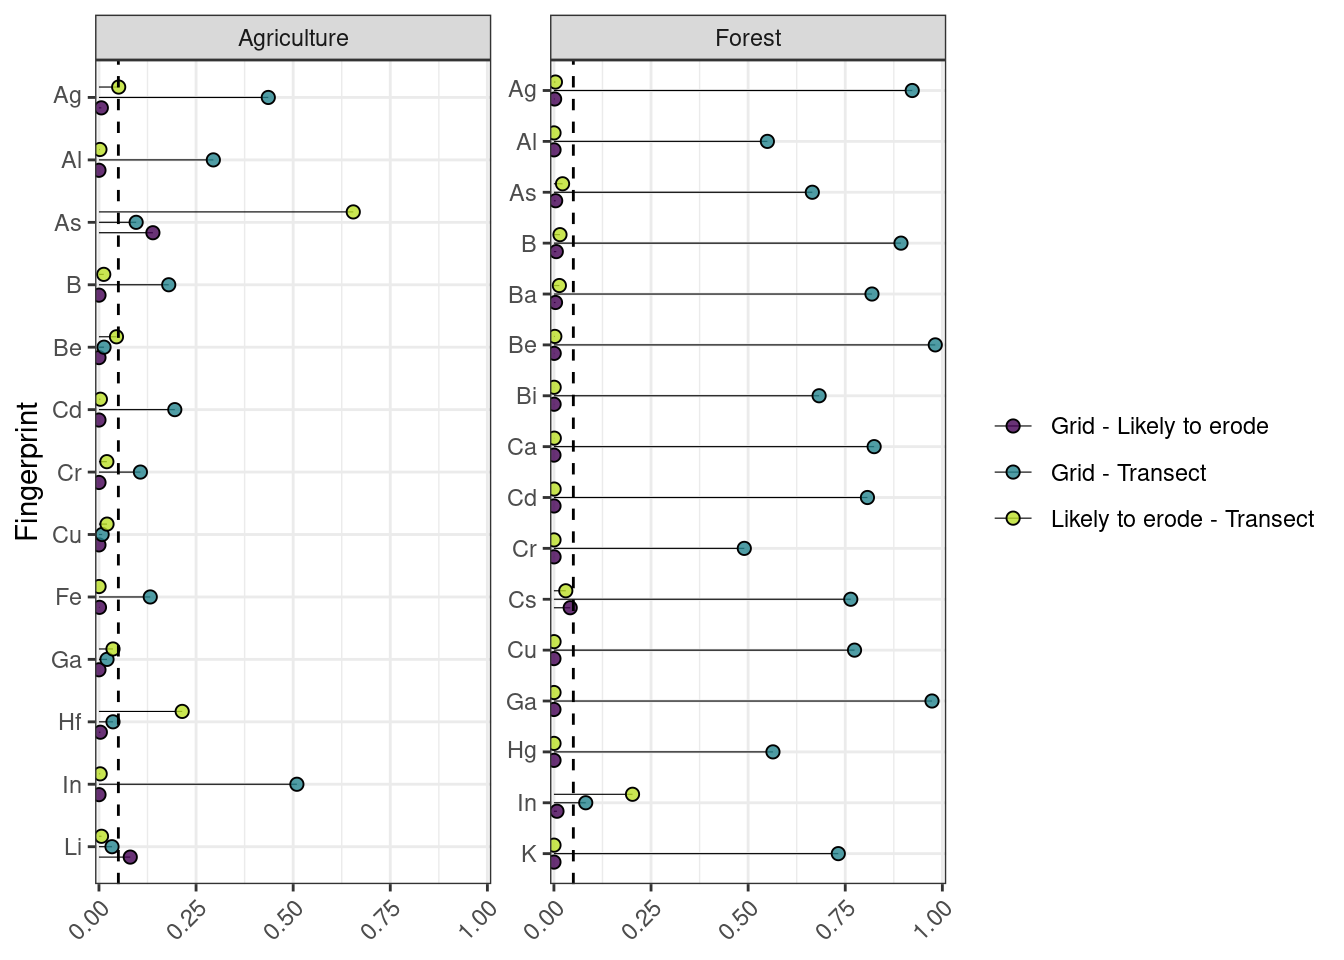

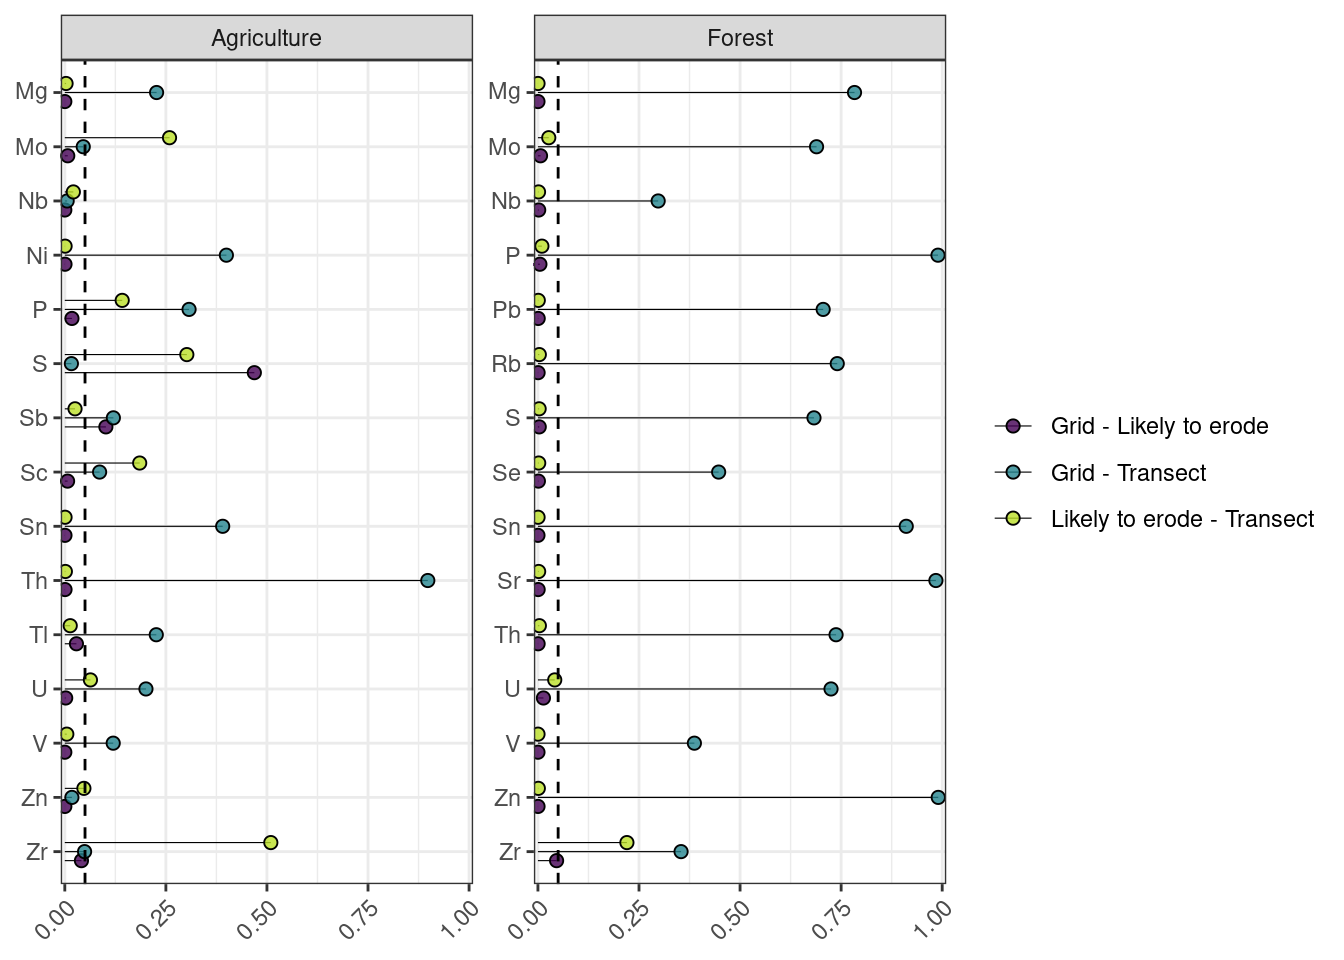

In [ ]:
dunn_p <- dunncolour %>%
  bind_rows(dunngeo) %>%
  mutate(start = 0) %>%
  mutate(group = case_when(type == "Colour" ~ "Colour",
                           type == "Geochemistry" & fingerprint %in% plot_ele ~ "Geochemistry (A-L)",
                           type == "Geochemistry" & !fingerprint %in% plot_ele ~ "Geochemistry (M-Z)")) %>%
  mutate(
    fingerprint = fct_relevel(
      fingerprint,
      c("R", "G", "B", "x", "y", "Y", "X", "Z", "L", "a", "b", "u", "v", "c", "h")),
    fingerprint = fct_relevel(fingerprint, c("Ag", "Al", "As"), 
                              after = which(levels(fingerprint) == "B") - 1),
    fingerprint = fct_relevel(fingerprint, c("Mg", "Mo", "Nb", "Ni", "P", "Pb", "Rb", "S", 
                                             "Sb", "Sc", "Se", "Sn", "Sr", "Th", "Tl", "U", "V"), 
                              after = which(levels(fingerprint) == "Y") - 1)) %>%
  mutate(fingerprint = fct_recode(
    fingerprint, 
    "italic(`a*`)" = "a", "italic(`b*`)" = "b", "italic(`c*`)" = "c", "italic(`h*`)" = "h", 
    "italic(`u*`)" = "u",  "italic(`v*`)" = "v"))


p2 <- ggplot(data = dunn_p, aes(y = fct_relevel(fingerprint, rev), x = P.adj, fill = Comparison)) +
  #geom_point(position = position_dodge(width = 0.2)) +
  geom_pointrange(aes(xmax= P.adj, xmin = 0), position = position_dodge(width = 0.5), linewidth = 0.2, shape = 21, stroke = 0.5) +
  geom_vline(xintercept = 0.05, linetype = "dashed") +
  theme_bw() +
  scale_x_continuous(expand = c(0.01,0), limits = c(0,1)) +
  scale_y_discrete(labels = label_parse()) +
  scale_fill_viridis_d(begin = 0, end = 0.9, alpha = 0.8) +
  theme(legend.position = "bottom",
        legend.title = element_blank()) +
  labs(x = expression(paste("Adjusted ", italic("p"), " value")), y = "Fingerprint") +
  facet_grid(group ~ site,scales = "free")
p2

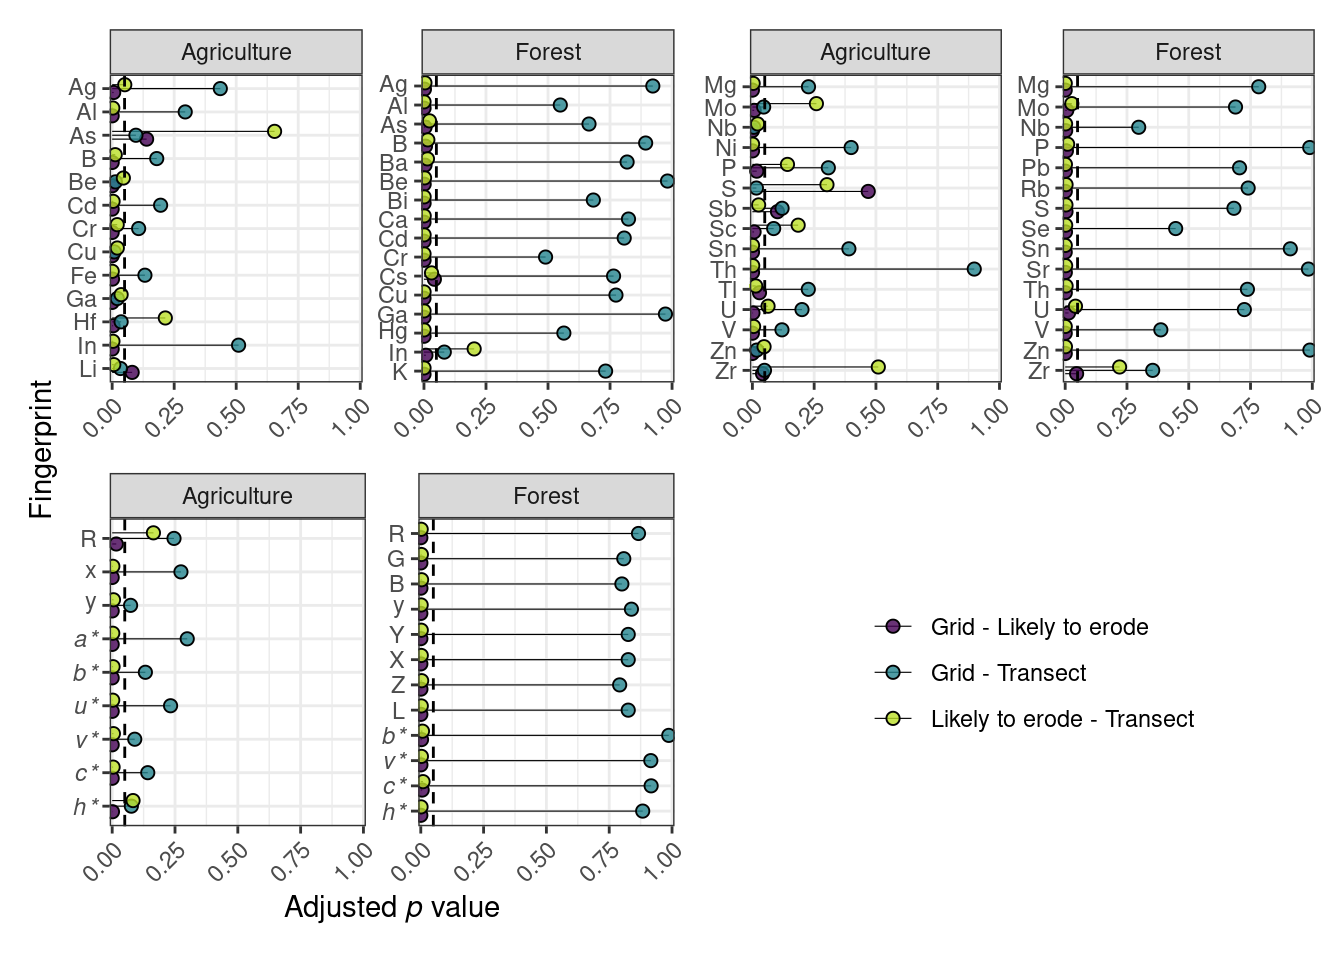

In [ ]:
#| label: fig-dunns-test
#| fig-cap: "Results for the pair-wise Dunn’s post-hoc test to determine differences in fingerprint properties between the three sampling designs for each site. Dashed line represents an α value of 0.05. Fingerprints that showed no significant differences (p value > 0.05) following the Kruskal Wallis test are not included."
p6 <- p4 + p5 + p3 + guide_area() + 
  plot_layout(guides = 'collect') + plot_layout(axis_titles = "collect")
p6